# Own Exploration

In [22]:
#import packages
import pandas as pd
import numpy as np
import matplotlib as plt


In [23]:
# Read the data from the file
df = pd.read_csv('Data/train_values.csv')
df_labels = pd.read_csv('Data/train_labels.csv')
test_df = pd.read_csv('Data/test_values.csv')

In [24]:
df.shape

(260601, 39)

In [25]:
import category_encoders as ce

    
def create_encoder(df):
    cols = ['ground_floor_type', 'land_surface_condition', 'foundation_type', 'roof_type', 
        'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status', 
    'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    
    encoder = ce.BinaryEncoder(cols=cols)
    encoder.fit(df)

    return encoder


def encode(df, encoder):
    """
    Binary encode the given dataframe using a pre-fitted encoder.
    """

    return encoder.transform(df)





In [26]:
print(df.shape)
print(test_df.shape)

(260601, 39)
(86868, 39)


In [27]:
encoder = create_encoder(df)


In [28]:
df = encode(df, encoder)
test_df = encode(test_df, encoder)

df.shape

(260601, 81)

In [29]:
df.columns

Index(['building_id', 'geo_level_1_id_0', 'geo_level_1_id_1',
       'geo_level_1_id_2', 'geo_level_1_id_3', 'geo_level_1_id_4',
       'geo_level_2_id_0', 'geo_level_2_id_1', 'geo_level_2_id_2',
       'geo_level_2_id_3', 'geo_level_2_id_4', 'geo_level_2_id_5',
       'geo_level_2_id_6', 'geo_level_2_id_7', 'geo_level_2_id_8',
       'geo_level_2_id_9', 'geo_level_2_id_10', 'geo_level_3_id_0',
       'geo_level_3_id_1', 'geo_level_3_id_2', 'geo_level_3_id_3',
       'geo_level_3_id_4', 'geo_level_3_id_5', 'geo_level_3_id_6',
       'geo_level_3_id_7', 'geo_level_3_id_8', 'geo_level_3_id_9',
       'geo_level_3_id_10', 'geo_level_3_id_11', 'geo_level_3_id_12',
       'geo_level_3_id_13', 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'land_surface_condition_0',
       'land_surface_condition_1', 'foundation_type_0', 'foundation_type_1',
       'foundation_type_2', 'roof_type_0', 'roof_type_1',
       'ground_floor_type_0', 'ground_floor_type_1', 'ground_fl

In [8]:
# Merge the dataframes
df_all = df.merge(df_labels, on='building_id')

In [10]:
#remove building id
df_all = df_all.drop(columns=['building_id'])

In [11]:
df_all.shape

(260601, 81)

In [12]:
df_all.dtypes

building_id                      int64
geo_level_1_id_0                 int64
geo_level_1_id_1                 int64
geo_level_1_id_2                 int64
geo_level_1_id_3                 int64
                                 ...  
has_secondary_use_health_post    int64
has_secondary_use_gov_office     int64
has_secondary_use_use_police     int64
has_secondary_use_other          int64
damage_grade                     int64
Length: 82, dtype: object

In [12]:
from sklearn.model_selection import train_test_split

# Define the predictor variables (X) and the target variable (y)
X = df_all.drop(['damage_grade'], axis=1)
y = df_all['damage_grade']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='damage_grade'>

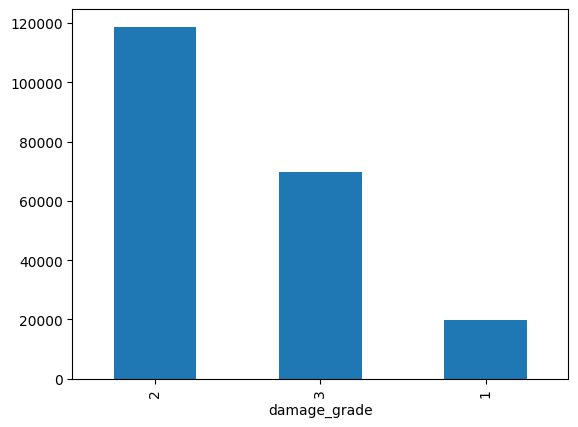

In [13]:
#plot of the damage grade
y_train.value_counts().plot(kind='bar')

In [47]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Combine the resampled X and y back into one dataset
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


<Axes: xlabel='damage_grade'>

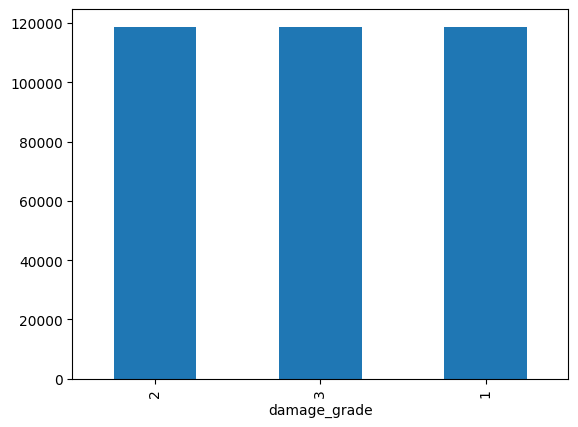

In [48]:
#plot of damage_grade in resampled_df
y_resampled.value_counts().plot(kind='bar')


## Optuna

In [54]:
def Optuna(X_train, y_train, X_test, y_test):

    import optuna
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    
    #change categories of y to start from 0 bc softmax likes it that way
    y_train = y_train - 1
    y_test = y_test - 1
        
    # Define an objective function for Optuna to optimize
    def objective(trial):
        # Define the hyperparameters to search
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        }

        # Create an XGBoost classifier with the suggested hyperparameters
        clf = xgb.XGBClassifier(**params, objective='multi:softmax', num_class=3)

        # Fit the classifier to the training data
        clf.fit(X_train, y_train)

        # Predict on the test data
        y_pred = clf.predict(X_test)

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate the micro F1 score
        micro_f1 = f1_score(y_test, y_pred, average='micro')

        return micro_f1  # Optimize for micro F1 score

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction='maximize')  # For micro F1, maximize the objective
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Get the best hyperparameters
    best_params = study.best_params
    best_micro_f1 = study.best_value

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Micro F1 Score: {best_micro_f1}")

    # Train a final model with the best hyperparameters
    best_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=3)
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    final_micro_f1 = f1_score(y_test, y_pred, average='micro')
    final_accuracy = accuracy_score(y_test, y_pred)

    print(f"Final Micro F1 Score with Best Hyperparameters: {final_micro_f1}")
    print(f"Final Accuracy with Best Hyperparameters: {final_accuracy}")

    # Print a classification report with precision, recall, and F1-score for each class
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)


In [55]:
Optuna(X_resampled, y_resampled, X_test, y_test)

/Users/katjad/anaconda3/envs/MiniCompetition/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-06 00:12:10,652] A new study created in memory with name: no-name-f1402b49-d27a-4ce4-b759-a05de6b3da96
/var/folders/24/zpxjl9zd4db1gltk61h_68_80000gn/T/ipykernel_28402/1723735459.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
/var/folders/24/zpxjl9zd4db1gltk61h_68_80000gn/T/ipykernel_28402/1723735459.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Best Hyperparameters: {'n_estimators': 710, 'max_depth': 10, 'learning_rate': 0.05278909553947987, 'subsample': 0.6360045463821926, 'colsample_bytree': 0.9587687071966036}
Best Micro F1 Score: 0.7404692926075862
Final Micro F1 Score with Best Hyperparameters: 0.7404692926075862
Final Accuracy with Best Hyperparameters: 0.7404692926075862
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.59      5170
           1       0.74      0.85      0.79     29487
           2       0.76      0.63      0.69     17464

    accuracy                           0.74     52121
   macro avg       0.73      0.66      0.69     52121
weighted avg       0.74      0.74      0.74     52121



## XG Boost

In [14]:
def XGBoost(X_train, y_train, X_test, y_test):
    """
    Create a XGBoost classifier and fit it to the train data.

    Args:
        training data set

    Returns:
        ?
    """

    import xgboost as xgb
    from sklearn.metrics import accuracy_score, f1_score

    #change categories of y to start from 0 bc softmax likes it that way
    y_train = y_train - 1
    y_test = y_test - 1

    # Define the hyperparameters
    hyperparameters = {
        'n_estimators': 535,
        'max_depth': 10,
        'learning_rate': 0.051232294238614126,
        'subsample': 0.6796645277288101,
        'colsample_bytree': 0.7886065868653529,
        'objective': 'multi:softmax',  # Specify multi-class classification objective
        'num_class': 3  # Number of classes in your multi-class problem
    }

    # Create an XGBoost classifier with the specified hyperparameters
    classifier = xgb.XGBClassifier(**hyperparameters)

    # Fit the classifier to the training data (X_train, y_train)
    classifier.fit(X_train, y_train)

    # Predict on the test data (X_test)
    y_pred = classifier.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate the micro F1 score
    micro_f1 = f1_score(y_test, y_pred, average='micro')

    return classifier, micro_f1, accuracy

In [15]:
# micro f1 and accuracy of XGBoost

model, micro_f1, accuracy  = XGBoost(X_train, y_train, X_test, y_test)

In [16]:
print(f'Micro F1 score: {micro_f1:.5f}')

Micro F1 score: 0.74734


In [69]:
# micro f1 and accuracy of XGBoost on resampled data

model_r, micro_f1_r, accuracy_r  = XGBoost(X_resampled, y_resampled, X_test, y_test)



Micro F1 score: 0.74233


In [71]:
print(f'Micro F1 score: {micro_f1_r:.5f}')

Micro F1 score: 0.74007


## predicting

In [17]:
import pandas as pd

def make_predictions(trained_model, new_data):
    """
    Make predictions on a new dataset using a trained XGBoost classifier.

    Args:
        trained_model: Trained XGBoost classifier
        new_data: New dataset for prediction

    Returns:
        predictions_df: DataFrame with 'building_id' and 'predictions'
    """
    
    # Create a copy of the new_data DataFrame to avoid modifying the original DataFrame
    new_data_copy = new_data.copy()

    # Remove the 'building_id' column if present in the new data (assuming it's not needed for prediction)
    if 'building_id' in new_data_copy.columns:
        new_data_copy = new_data_copy.drop(['building_id'], axis=1)

    # Make predictions on the new data
    predictions = trained_model.predict(new_data_copy)

    # Add 1 to the predictions to revert to the original damage_grade values
    predictions = predictions + 1

    # Create a DataFrame with 'building_id' and 'predictions'
    predictions_df = pd.DataFrame({'building_id': new_data['building_id'], 'damage_grade': predictions})

    return predictions_df


In [18]:
predicted = make_predictions(model, test_df)

In [19]:
predicted

,building_id,predictions
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,2
86865,1049160,2
86866,442785,2


In [20]:
# Save the data frame to a csv file
predicted.to_csv('predicted.csv', index=False)